# Lab 2: Transfer Learning and Transformers — by Eddie Diaz

## Overview of the Dataset

In this lab, I will use transfer learning to classify the emotional context of text strings. Although this classification task is multi-class — not merely positive or negative in sentiment, but multiple categories are possible — it is not multi-task, as there is only one label assigned to each particular value. 

Throughout this lab, I will use [this dataset](https://github.com/dair-ai/emotion_dataset), which consists of 20,000 English text samples from Twitter. The dataset is unimodal, as it is solely text-based. Each unique string value has a corresponding label with the following possible values:

    - 0: sadness
    - 1: love
    - 2: joy
    - 3: anger
    - 4: fear
    - 5: surprise

This data was originally collected by the National Tsing Hua University in Taiwan, and it was used for a semi-supervised graph-based model to better process and understand the nuanced nature of emotional context from text samples. Further detail on the origin may be found in [this paper](https://aclanthology.org/D18-1404/).

To evaluate the performance of the models, accuracy will serve as the primary metric. This choice is based on its clear and straightforward measure of model performance across all classes. Even though the dataset exhibits some imbalance, accuracy will suffice for this context where the implications of misclassifications are equally inconsequential for all classes. As a correct percentage of total predictions, accuracy offers a direct assessment of the models' capabilities to interpret the emotional content.

## Foundational Model

My foundational model of choice for this assignment is BERT. A natural language model that was initially trained on extensive text data for tasks like next-sentence prediction, BERT's pretraining  pre-training helps it understand the context and semantics of the English language and suits this task perfectly. As such, a downstream task within its same domain of English text analysis should see a massive spike in performance when using BERT.

The specific model is [uncased English BERT](https://huggingface.co/transformers/v3.3.1/model_doc/bert.html) from on Hugging Face. The TFBertModel inherits from the pre-trained model based on the original BERT paper; however, it has been formatted for use with Tensorflow.

## Data Split

Although the dataset is already pre-split with an 80-20 train-test ratio, I want to perform my own. I could not find evidence of stratification in the original split, but a brief overview does show the dataset is imbalanced. This distribution can be detrimental to our evaluation because we are using accuracy. A lack of exposure to a specific class will result in incorrect predictions, so I'll mitigate this risk by ensuring the data is stratified. To do this, I'll download data from all three csv files in the Emotion folder and print a single dataframe.

In [1]:
import pandas as pd

# Define the file paths
train_path = 'Emotion/training.csv'
test_path = 'Emotion/test.csv'
validation_path = 'Emotion/validation.csv'

# Load the datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
validation_df = pd.read_csv(validation_path)

# Combine the datasets
df = pd.concat([train_df, test_df, validation_df], ignore_index=True)

print(df.head())
print(df.count())


                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
text     20000
label    20000
dtype: int64


Now, we can use scikit-learn to split the data in 80-20 while ensuring the y values are stratified. This procedure will maintain the same proportion of labels across both datasets, and can therefore improve our results by addressing the problem I mentioned earlier.

In [3]:
from sklearn.model_selection import train_test_split

# Define X and y
X = df['text']
y = df['label']

# Perform a stratified split with 80-20 ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [4]:
# Print the shapes of the resulting splits to verify
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")

Training set shape: (16000,), Validation set shape: (4000,)


In [5]:
import tensorflow as tf

# Prepare the data by converting pandas series to numpy array
X_train_values = X_train.values
y_train_values = y_train.values

# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_values, y_train_values))
train_dataset = train_dataset.batch(32).shuffle(buffer_size=1024).prefetch(tf.data.AUTOTUNE)

2024-03-07 18:05:28.332971: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-07 18:05:28.332993: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2024-03-07 18:05:28.332997: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2024-03-07 18:05:28.333028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-07 18:05:28.333043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Transformer from Scratch

Before I create my model, I would like to find the size of my dataset's vocabulary and the length of 95% of the Tweets. Even though a Tweet had a max_length of 280 for a long time, using this as the max length of my embeddings will likely result in a lot of empty padding. To avoid this, I will use a lambda function to get the approximate 95th percent quantile's length in the distribution. In addition, I will use the Tensorflow tokenizer to easily find my vocabulary size. By figuring out these values, I will best be able to save computational resources within my model's training.

In [6]:
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer

# Determine max length
tweet_lengths = df['text'].apply(lambda x: len(x))
max_len = int(tweet_lengths.quantile(0.95))  # Get the 95th percentile
print(max_len)

# Determine vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
word_counts = Counter(tokenizer.word_counts)
vocab_size = len([word for word, count in word_counts.items() if count > 1])
print(vocab_size)


207
8428


Using the above values as parameters, we can begin modeling. This model will be a simple rudimentary transformer to process text. The model consists of an input layer, text vectorization, and an embedding layer, which will convert text into numerical data and begin analyzing relationships between words. Then, a multi head attention will allow the model to predict missing words and therefore understand the order of phrases. A global pooling layer will standardize the output vector before finally feeding it into two dense layers to perform the classification.

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, MultiHeadAttention, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Define parameters to values set above, the others were set to standard sizes on the safe side of computationally efficient
VOCAB_SIZE = vocab_size    
MAX_LEN = max_len    
EMBED_DIM = 207
NUM_HEADS = 4
FF_DIM = 207

# Building the model, as defined in markdown above
def build_model(vocab_size, embed_dim, num_heads, ff_dim, max_len, num_classes):
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
    text_vectorization = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=max_len)
    text_vectorization.adapt(X_train_values)
    
    x = text_vectorization(inputs)
    embedding_layer = Embedding(vocab_size, embed_dim, embeddings_regularizer=l2(1e-6))
    x = embedding_layer(x)
    
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, attention_axes=(1,))(x, x)
    x = Dropout(0.1)(attention_output)  # Added dropout because my loss was getting out of control
    x = GlobalAveragePooling1D()(x)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(0.1)(x) 
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# Compile the model
model = build_model(VOCAB_SIZE, EMBED_DIM, NUM_HEADS, FF_DIM, MAX_LEN, num_classes=6)
model.compile(Adam(learning_rate=0.0001), "sparse_categorical_crossentropy", metrics=["accuracy"])


2024-03-07 18:05:40.972886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [8]:
# custom callback to save metrics for statistical analysis
class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self, filename_prefix):
        super(MetricsLogger, self).__init__()
        self.val_accuracies = []
        self.runtimes = []
        self.start_time = time.time()
        self.filename_prefix = filename_prefix

    def on_epoch_end(self, epoch, logs=None):
        self.val_accuracies.append(logs.get('val_accuracy'))
        self.runtimes.append(time.time() - self.start_time)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        with open(f'{self.filename_prefix}_val_accuracies.pkl', 'wb') as f:
            pickle.dump(self.val_accuracies, f)
        with open(f'{self.filename_prefix}_runtimes.pkl', 'wb') as f:
            pickle.dump(self.runtimes, f)

Now that we created the model, let's run it to convergence, and analyze its performance. To do this we'll implement two callback functions — early stopping and checkpoint — to find when the model stops improving and save the model.

Epoch 1/50


2024-03-07 18:06:02.077860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 1.5903 - accuracy: 0.3295

2024-03-07 18:07:49.667295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 123s 239ms/step - loss: 1.5903 - accuracy: 0.3295 - val_loss: 1.5761 - val_accuracy: 0.3380
Epoch 2/50
500/500 [==============================] - 115s 231ms/step - loss: 1.5750 - accuracy: 0.3346 - val_loss: 1.5728 - val_accuracy: 0.3380
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 1.3516 - accuracy: 0.4022INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


500/500 [==============================] - 116s 231ms/step - loss: 1.3516 - accuracy: 0.4022 - val_loss: 1.1535 - val_accuracy: 0.4193
Epoch 4/50
500/500 [==============================] - 114s 229ms/step - loss: 20.8300 - accuracy: 0.3999 - val_loss: 42.8447 - val_accuracy: 0.4045
Epoch 5/50
500/500 [==============================] - 115s 229ms/step - loss: 175.8572 - accuracy: 0.3724 - val_loss: 190.0450 - val_accuracy: 0.3943
Epoch 6/50
500/500 [==============================] - 115s 230ms/step - loss: 411.9282 - accuracy: 0.3644 - val_loss: 529.4728 - val_accuracy: 0.3715


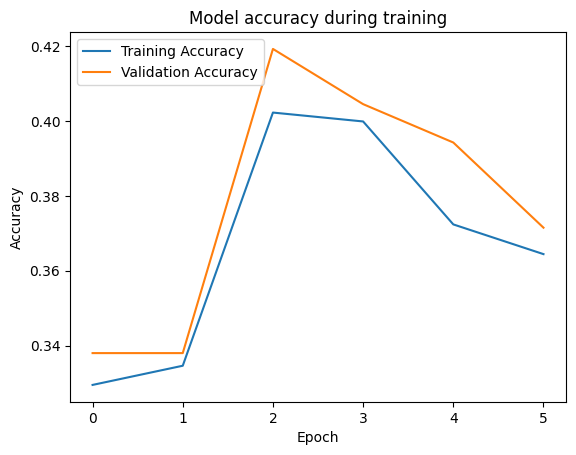

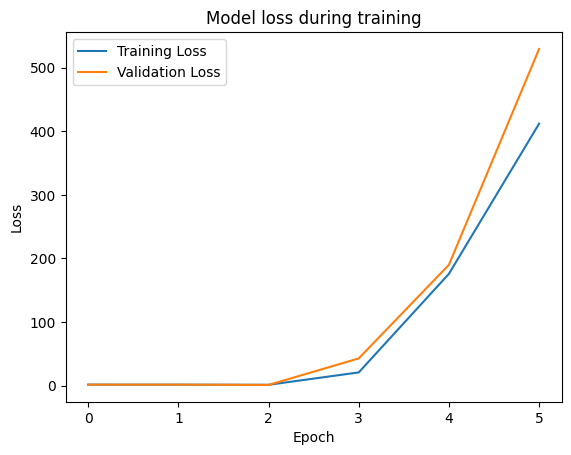

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import time
import pickle

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Callback for checkpointing the best model
checkpoint = ModelCheckpoint(
    'best_model',
    monitor='val_accuracy',
    save_best_only=True,
    save_format='tf'
)

# Instantiate the metrics callback with a unique prefix
metrics_logger_scratch = MetricsLogger(filename_prefix='scratch')

# Format validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Model training with early stopping and model checkpointing
history = model.fit(
    train_dataset,
    epochs=50,  # Large number of epochs to let early stopping end the training
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, metrics_logger_scratch]
)

# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy during training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

From these results, we can see that the model is converging quite early, which makes sense for a relatively small dataset and simple task. In previous iterations of my work, I was using Python3.12 and Tensorflow 2.16, notably, the newer technologies resulted in much higher accuracy for this model — from 38% to 90% validation accuracy at convergence. In addition, newer dependencies needed about half the runtime needed to converge. Nevertheless, I downgraded to Python 3.8 due to dependency issues with Hugging Face transformers. 

Also, the validation loss seems to be getting out of hand exponentially with more epochs, showing signs that the model may be overfitting the data. Thats ok though! We can still compare this performance to the foundational model.

## Transfer Learning

Before training with BERT, we need to format the data to fit the model's requirements. This can be easily achieved by using the BERT Tokenizer from Tensorflow.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel, BertTokenizer
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input text
def encode_sentences(sentences):
    return tokenizer(sentences, padding='max_length', truncation=True, max_length=128, return_tensors='tf')

# Encoding training and validation data
X_train_encoded = encode_sentences(X_train.tolist())
X_val_encoded = encode_sentences(X_val.tolist())

After we have our tokens, we can train a model using BERT for feature extraction. I added two dense layers at the end for the classification task, these use the same architecture as the model above, but the first Dense layer is a little wider to account for additional resources.

In [11]:
# Load the pre-trained BERT model
bert = TFBertModel.from_pretrained('bert-base-uncased')

# Freeze the BERT model to use it as a feature extractor only
bert.trainable = False

# Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# BERT embeddings
embeddings = bert(input_ids, attention_mask=attention_mask)[1]

# Classifier on top of BERT embeddings
# Dropout did not seem necessary
x = Dense(1024, activation='relu')(embeddings)
y = Dense(6, activation='softmax')(x)

# Final model
model = Model(inputs=[input_ids, attention_mask], outputs=y)

# Compile the model
model.compile(optimizer=Adam(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Let's run the model to convergence.

Epoch 1/50


2024-03-07 18:19:19.940422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 1.5708 - accuracy: 0.3539

2024-03-07 18:20:52.989213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 141s 228ms/step - loss: 1.5708 - accuracy: 0.3539 - val_loss: 1.5292 - val_accuracy: 0.4162
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 1.5243 - accuracy: 0.4096INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 95s 191ms/step - loss: 1.5243 - accuracy: 0.4096 - val_loss: 1.4805 - val_accuracy: 0.4403
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 1.4953 - accuracy: 0.4318INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 109s 218ms/step - loss: 1.4953 - accuracy: 0.4318 - val_loss: 1.4488 - val_accuracy: 0.4593
Epoch 4/50
500/500 [==============================] - ETA: 0s - loss: 1.4762 - accuracy: 0.4339INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 107s 215ms/step - loss: 1.4762 - accuracy: 0.4339 - val_loss: 1.4315 - val_accuracy: 0.4642
Epoch 5/50
500/500 [==============================] - ETA: 0s - loss: 1.4601 - accuracy: 0.4468INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 100s 200ms/step - loss: 1.4601 - accuracy: 0.4468 - val_loss: 1.4080 - val_accuracy: 0.4655
Epoch 6/50
500/500 [==============================] - ETA: 0s - loss: 1.4476 - accuracy: 0.4521INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 97s 195ms/step - loss: 1.4476 - accuracy: 0.4521 - val_loss: 1.3970 - val_accuracy: 0.4775
Epoch 7/50
500/500 [==============================] - 85s 170ms/step - loss: 1.4375 - accuracy: 0.4561 - val_loss: 1.3970 - val_accuracy: 0.4575
Epoch 8/50
500/500 [==============================] - ETA: 0s - loss: 1.4253 - accuracy: 0.4602INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 98s 197ms/step - loss: 1.4253 - accuracy: 0.4602 - val_loss: 1.3832 - val_accuracy: 0.4910
Epoch 9/50
500/500 [==============================] - ETA: 0s - loss: 1.4212 - accuracy: 0.4588INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 98s 196ms/step - loss: 1.4212 - accuracy: 0.4588 - val_loss: 1.3660 - val_accuracy: 0.4913
Epoch 10/50
500/500 [==============================] - ETA: 0s - loss: 1.4137 - accuracy: 0.4624INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 95s 191ms/step - loss: 1.4137 - accuracy: 0.4624 - val_loss: 1.3570 - val_accuracy: 0.4945
Epoch 11/50
500/500 [==============================] - 85s 169ms/step - loss: 1.4069 - accuracy: 0.4663 - val_loss: 1.3466 - val_accuracy: 0.4922
Epoch 12/50
500/500 [==============================] - ETA: 0s - loss: 1.4010 - accuracy: 0.4669INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 100s 199ms/step - loss: 1.4010 - accuracy: 0.4669 - val_loss: 1.3371 - val_accuracy: 0.5000
Epoch 13/50
500/500 [==============================] - 88s 175ms/step - loss: 1.3906 - accuracy: 0.4742 - val_loss: 1.3389 - val_accuracy: 0.4975
Epoch 14/50
500/500 [==============================] - ETA: 0s - loss: 1.3885 - accuracy: 0.4712INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 100s 200ms/step - loss: 1.3885 - accuracy: 0.4712 - val_loss: 1.3200 - val_accuracy: 0.5045
Epoch 15/50
500/500 [==============================] - ETA: 0s - loss: 1.3833 - accuracy: 0.4730INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 99s 198ms/step - loss: 1.3833 - accuracy: 0.4730 - val_loss: 1.3243 - val_accuracy: 0.5098
Epoch 16/50
500/500 [==============================] - 85s 171ms/step - loss: 1.3808 - accuracy: 0.4756 - val_loss: 1.3310 - val_accuracy: 0.4945
Epoch 17/50
500/500 [==============================] - ETA: 0s - loss: 1.3765 - accuracy: 0.4794INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 100s 199ms/step - loss: 1.3765 - accuracy: 0.4794 - val_loss: 1.3089 - val_accuracy: 0.5145
Epoch 18/50
500/500 [==============================] - 88s 177ms/step - loss: 1.3725 - accuracy: 0.4806 - val_loss: 1.3015 - val_accuracy: 0.5107
Epoch 19/50
500/500 [==============================] - ETA: 0s - loss: 1.3712 - accuracy: 0.4801INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


500/500 [==============================] - 102s 204ms/step - loss: 1.3712 - accuracy: 0.4801 - val_loss: 1.3083 - val_accuracy: 0.5197
Epoch 20/50
500/500 [==============================] - 90s 179ms/step - loss: 1.3694 - accuracy: 0.4836 - val_loss: 1.2992 - val_accuracy: 0.5073
Epoch 21/50
500/500 [==============================] - 91s 182ms/step - loss: 1.3672 - accuracy: 0.4782 - val_loss: 1.3025 - val_accuracy: 0.5095
Epoch 22/50
500/500 [==============================] - 92s 185ms/step - loss: 1.3640 - accuracy: 0.4834 - val_loss: 1.2936 - val_accuracy: 0.5098
INFO:tensorflow:Assets written to: transfer_model/assets


INFO:tensorflow:Assets written to: transfer_model/assets


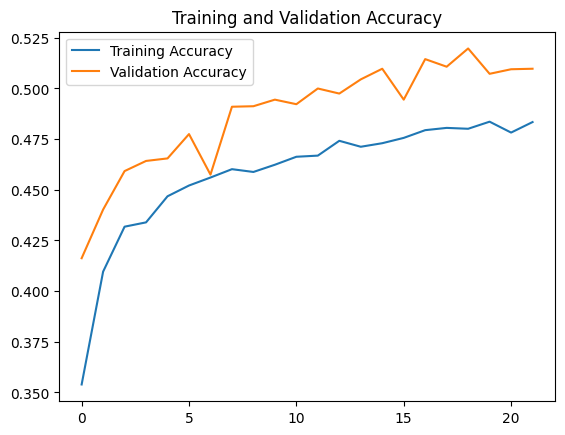

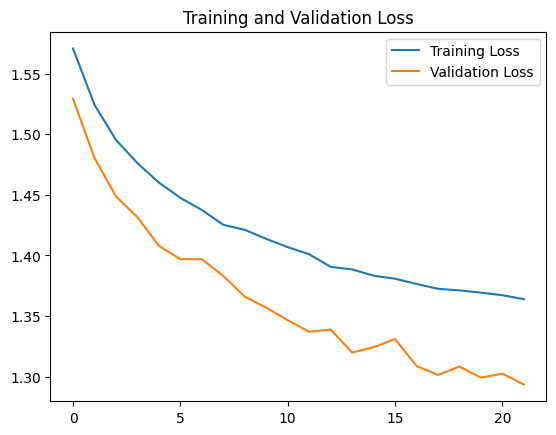

In [12]:
# I'll use the same early stopping function, but a new checkpoint to save a new model
checkpoint = ModelCheckpoint('transfer_model', monitor='val_accuracy', save_best_only=True, save_format='tf')

# Instantiate the custom callback with a different filename prefix
metrics_logger_bert = MetricsLogger(filename_prefix='bert')

history = model.fit(
    {'input_ids': X_train_encoded['input_ids'], 'attention_mask': X_train_encoded['attention_mask']},
    y_train,
    validation_data=(
        {'input_ids': X_val_encoded['input_ids'], 'attention_mask': X_val_encoded['attention_mask']},
        y_val
    ),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, checkpoint, metrics_logger_bert]
)

# Save the best model
model.save('transfer_model', save_format='tf')

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Already, we can se an improvement in validation accuracy, albeit a little less than expected. Furthermore, the decreasing loss shows that we are far from overfitting the data. This is likely due to the more extensive pretraining and large vocabulary present in the BERT model, which is untainted with the frozen layers. However, this improvement came at a large cost, as the training time is almost three times as the scratch model. Although the model made small improvements after reaching 50% validation accuracy after 13 epochs, these later epochs costed a lot of computational resources.

## Was it worth it? Statistical Analysis 1

Because we noted the increase in time and memory, we must ask if this 10% increase in performance is substantial. Furthermore, we can also inquire whether the runtime increase is significant when accounting for a greater number of epochs. To assess these questions, we need to conduct a statistical test. Typically, I'd use a test like the paired t-test. Nevetheless, due to the uneven distribution of data in the Transfer Learning model, a non-parametric test like the Wilcoxon signed-rank test seems more appropriate. This test will be performed with the metrics I saved with the custom callback function. However, the additional epochs taken by the Transfer Learning model cause an issue when performing a test. Therefore, we need another custom function to truncate the logs. To best illustrate the difference in performance, I'll truncate the beginning of the BERT metrics, when the model was far from convergence.



In [14]:
from scipy.stats import wilcoxon

# Load two sets of metrics and truncate the larger one to match the smaller one
def load_and_truncate_data(model_name_1, model_name_2, metric):
    data_1 = load_metrics(f'{model_name_1}_{metric}.pkl')
    data_2 = load_metrics(f'{model_name_2}_{metric}.pkl')
    
    # Find the length difference
    len_diff = abs(len(data_1) - len(data_2))
    
    # If data_1 is longer, truncate from the start
    if len(data_1) > len(data_2):
        data_1_truncated = data_1[len_diff:]
        data_2_truncated = data_2
    # If data_2 is longer, truncate from the start
    elif len(data_2) > len(data_1):
        data_1_truncated = data_1
        data_2_truncated = data_2[len_diff:]
    else:
        # No truncation needed if they are of the same length
        data_1_truncated = data_1
        data_2_truncated = data_2
    
    return data_1_truncated, data_2_truncated

# Use this function to load and truncate validation accuracies and runtimes
val_acc_scratch, val_acc_bert = load_and_truncate_data('scratch', 'bert', 'val_accuracies')
runtime_scratch, runtime_bert = load_and_truncate_data('scratch', 'bert', 'runtimes')

# Conduct Wilcoxon signed-rank tests
# For validation accuracies
stat_val_acc, p_val_acc = wilcoxon(val_acc_scratch, val_acc_bert)
print(f'Validation Accuracy - Wilcoxon signed-rank test: Stat={stat_val_acc}, p={p_val_acc}')

# For runtimes
stat_runtime, p_runtime = wilcoxon(runtime_scratch, runtime_bert)
print(f'Runtime - Wilcoxon signed-rank test: Stat={stat_runtime}, p={p_runtime}')

# Interpretation
alpha = 0.05
if p_val_acc < alpha:
    print('Significant difference in validation accuracies (reject H0)')
else:
    print('No significant difference in validation accuracies (fail to reject H0)')

if p_runtime < alpha:
    print('Significant difference in runtime (reject H0)')
else:
    print('No significant difference in runtime (fail to reject H0)')


Validation Accuracy - Wilcoxon signed-rank test: Stat=0.0, p=0.03125
Runtime - Wilcoxon signed-rank test: Stat=0.0, p=0.03125
Significant difference in validation accuracies (reject H0)
Significant difference in runtime (reject H0)


From the above statistical test, we can conclude that the inclusion of BERT, even when not trainable, is a statistically significant improvement on performance. However, this comes at a cost of a statistically significant increase in runtime, even when accounting for an equal number of epochs.

## Fine Tuning

Let's see if we can fine tune the model to further increase it's performance. I believe the trend of increased computational resources will continue here. To fine tune the model, we can basically just enable the layers to be trainable, and re-compile the model.

In [15]:
# Make BERT layers trainable
for layer in bert.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=2e-5),  # We'll use a smaller learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Now we can run the model with trainable layers. Originally, I set only the top 4 layers to be trainable to save myself some time and memory; however, this small change resulted in a drop in performance and some signs of overfitting. Perhaps this is because BERT is usually trained on larger amounts of data, and forcing it to tune itself to the small dataset in this task may cause it to lose valuable insights from other sources that could improve it's performance with the classification task. Let's see how it does with a fully trainable model.

Epoch 1/50


2024-03-07 19:25:42.021659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 1.3650 - accuracy: 0.4812

2024-03-07 19:27:14.454186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: fine_tuned_model/assets


INFO:tensorflow:Assets written to: fine_tuned_model/assets


500/500 [==============================] - 142s 229ms/step - loss: 1.3650 - accuracy: 0.4812 - val_loss: 1.3161 - val_accuracy: 0.5048
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 1.3675 - accuracy: 0.4811INFO:tensorflow:Assets written to: fine_tuned_model/assets


INFO:tensorflow:Assets written to: fine_tuned_model/assets


500/500 [==============================] - 94s 189ms/step - loss: 1.3675 - accuracy: 0.4811 - val_loss: 1.3017 - val_accuracy: 0.5132
Epoch 3/50
500/500 [==============================] - 82s 164ms/step - loss: 1.3617 - accuracy: 0.4854 - val_loss: 1.2870 - val_accuracy: 0.5130
Epoch 4/50
500/500 [==============================] - ETA: 0s - loss: 1.3603 - accuracy: 0.4856INFO:tensorflow:Assets written to: fine_tuned_model/assets


INFO:tensorflow:Assets written to: fine_tuned_model/assets


500/500 [==============================] - 100s 200ms/step - loss: 1.3603 - accuracy: 0.4856 - val_loss: 1.2881 - val_accuracy: 0.5210
Epoch 5/50
500/500 [==============================] - 90s 181ms/step - loss: 1.3605 - accuracy: 0.4830 - val_loss: 1.2843 - val_accuracy: 0.5082
Epoch 6/50
500/500 [==============================] - ETA: 0s - loss: 1.3496 - accuracy: 0.4892INFO:tensorflow:Assets written to: fine_tuned_model/assets


INFO:tensorflow:Assets written to: fine_tuned_model/assets


500/500 [==============================] - 102s 204ms/step - loss: 1.3496 - accuracy: 0.4892 - val_loss: 1.2910 - val_accuracy: 0.5242
Epoch 7/50
500/500 [==============================] - ETA: 0s - loss: 1.3534 - accuracy: 0.4876INFO:tensorflow:Assets written to: fine_tuned_model/assets


INFO:tensorflow:Assets written to: fine_tuned_model/assets


500/500 [==============================] - 101s 202ms/step - loss: 1.3534 - accuracy: 0.4876 - val_loss: 1.2782 - val_accuracy: 0.5328
Epoch 8/50
500/500 [==============================] - 86s 172ms/step - loss: 1.3509 - accuracy: 0.4862 - val_loss: 1.2774 - val_accuracy: 0.5195
Epoch 9/50
500/500 [==============================] - 88s 175ms/step - loss: 1.3473 - accuracy: 0.4879 - val_loss: 1.2714 - val_accuracy: 0.5230
Epoch 10/50
125/125 [==============================] - 18s 140ms/step - loss: 1.2782 - accuracy: 0.5328
Validation Loss: 1.2782001495361328
Validation Accuracy: 0.5327500104904175


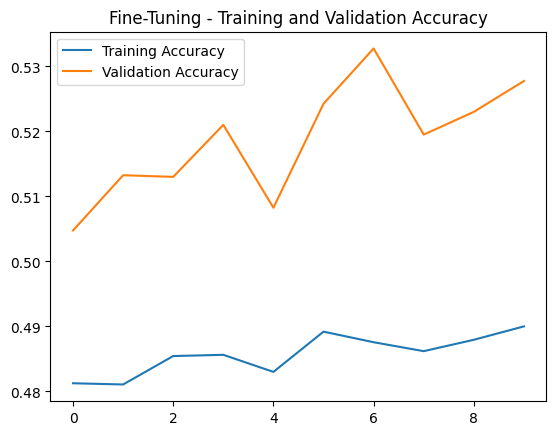

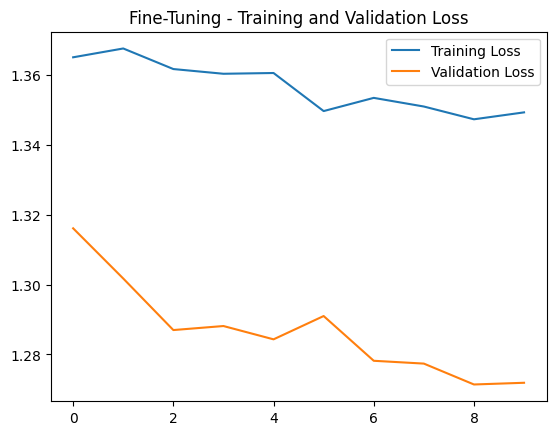

In [16]:
# Define checkpoint callback
checkpoint = ModelCheckpoint('fine_tuned_model', monitor='val_accuracy', save_best_only=True, save_format='tf')

# Instantiate metrics callback with a different prefix
metrics_logger_tuned = MetricsLogger(filename_prefix='tuned')

# Fine-tuning model training
history_fine = model.fit(
    {'input_ids': X_train_encoded['input_ids'], 'attention_mask': X_train_encoded['attention_mask']},
    y_train,
    validation_data=(
        {'input_ids': X_val_encoded['input_ids'], 'attention_mask': X_val_encoded['attention_mask']},
        y_val
    ),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, checkpoint, metrics_logger_tuned]
)

# Evaluate the fine-tuned model
val_loss, val_accuracy = model.evaluate(
    {'input_ids': X_val_encoded['input_ids'], 'attention_mask': X_val_encoded['attention_mask']},
    y_val
)
print(f"Validation Loss: {val_loss}\nValidation Accuracy: {val_accuracy}")

# Plot accuracy
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-Tuning - Training and Validation Accuracy')
plt.legend()

plt.figure()

# Plot loss
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Fine-Tuning - Training and Validation Loss')
plt.legend()
plt.show()

After unfreezing the trainable layers, the model converged much quicker. However, the results seem much more volatile, and the overall improvement was only a few percentages. We'll have to conduct another statistical test to see if enabling these layers is really worth it.

## Fine Tuning Statistical Analysis

This statistical test will follow the same procedure as above. Both runtime and validation accuracy will be tested with the Wilcoxon test.

In [17]:
# Use this function to load and truncate validation accuracies and runtimes
val_acc_tuned, val_acc_bert = load_and_truncate_data('tuned', 'bert', 'val_accuracies')
runtime_tuned, runtime_bert = load_and_truncate_data('tuned', 'bert', 'runtimes')

# Conduct Wilcoxon signed-rank tests
# For validation accuracies
stat_val_acc, p_val_acc = wilcoxon(val_acc_tuned, val_acc_bert)
print(f'Validation Accuracy - Wilcoxon signed-rank test: Stat={stat_val_acc}, p={p_val_acc}')

# For runtimes
stat_runtime, p_runtime = wilcoxon(runtime_tuned, runtime_bert)
print(f'Runtime - Wilcoxon signed-rank test: Stat={stat_runtime}, p={p_runtime}')

# Interpretation
alpha = 0.05
if p_val_acc < alpha:
    print('Significant difference in validation accuracies (reject H0)')
else:
    print('No significant difference in validation accuracies (fail to reject H0)')

if p_runtime < alpha:
    print('Significant difference in runtime (reject H0)')
else:
    print('No significant difference in runtime (fail to reject H0)')

Validation Accuracy - Wilcoxon signed-rank test: Stat=2.0, p=0.005859375
Runtime - Wilcoxon signed-rank test: Stat=25.0, p=0.845703125
Significant difference in validation accuracies (reject H0)
No significant difference in runtime (fail to reject H0)


From the statistical test performed, it's evident that the few percentages added by unfreezing the trainable layers to fine tune BERT to our classification task is indeed statistically significant. This may be due to the fact that the model without fine tuning took 13 epochs to reach accuracies over 50%, whereas the fine tuned model always performed at this range. Therefore, the fine tuned model is always better than the original model, even if its results seem a bit more volatile.

In contrast, there is no significant difference in runtime between both models. Even though the fine tuned model converged much faster, when adjusting for the difference in layers, there does not seem to be a substantial difference. This conclusion further solidifies that Transfer Learning should always explore fine tuning, as it is purely advantageous to the classification task.